In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# 设置中文显示，解决乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [4]:
# 读取数据
df = pd.read_pickle('../BeijingRent.pkl')

In [5]:
# 提取地理位置分析数据
data = pd.DataFrame({
    'id':df['id'],
    'time':df['tradeTime'],
    'lng':df['Lng'],
    'lat':df['Lat'],
    'district':df['district'],
    'subway':df['subway'],
    'price_per_square':df['price'],
    'total_price':df['totalPrice']
}).set_index('id')

In [6]:
data.sort_values(by='time', ascending=True, inplace=True)

In [7]:
data['year'] = data['time'].dt.to_period('Y')
data['month'] =data['time'].dt.to_period('M')

C:\Users\wesley\AppData\Local\Temp\ipykernel_10808\616627989.py:15: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  k = kde.gaussian_kde([x, y])
C:\Users\wesley\AppData\Local\Temp\ipykernel_10808\616627989.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


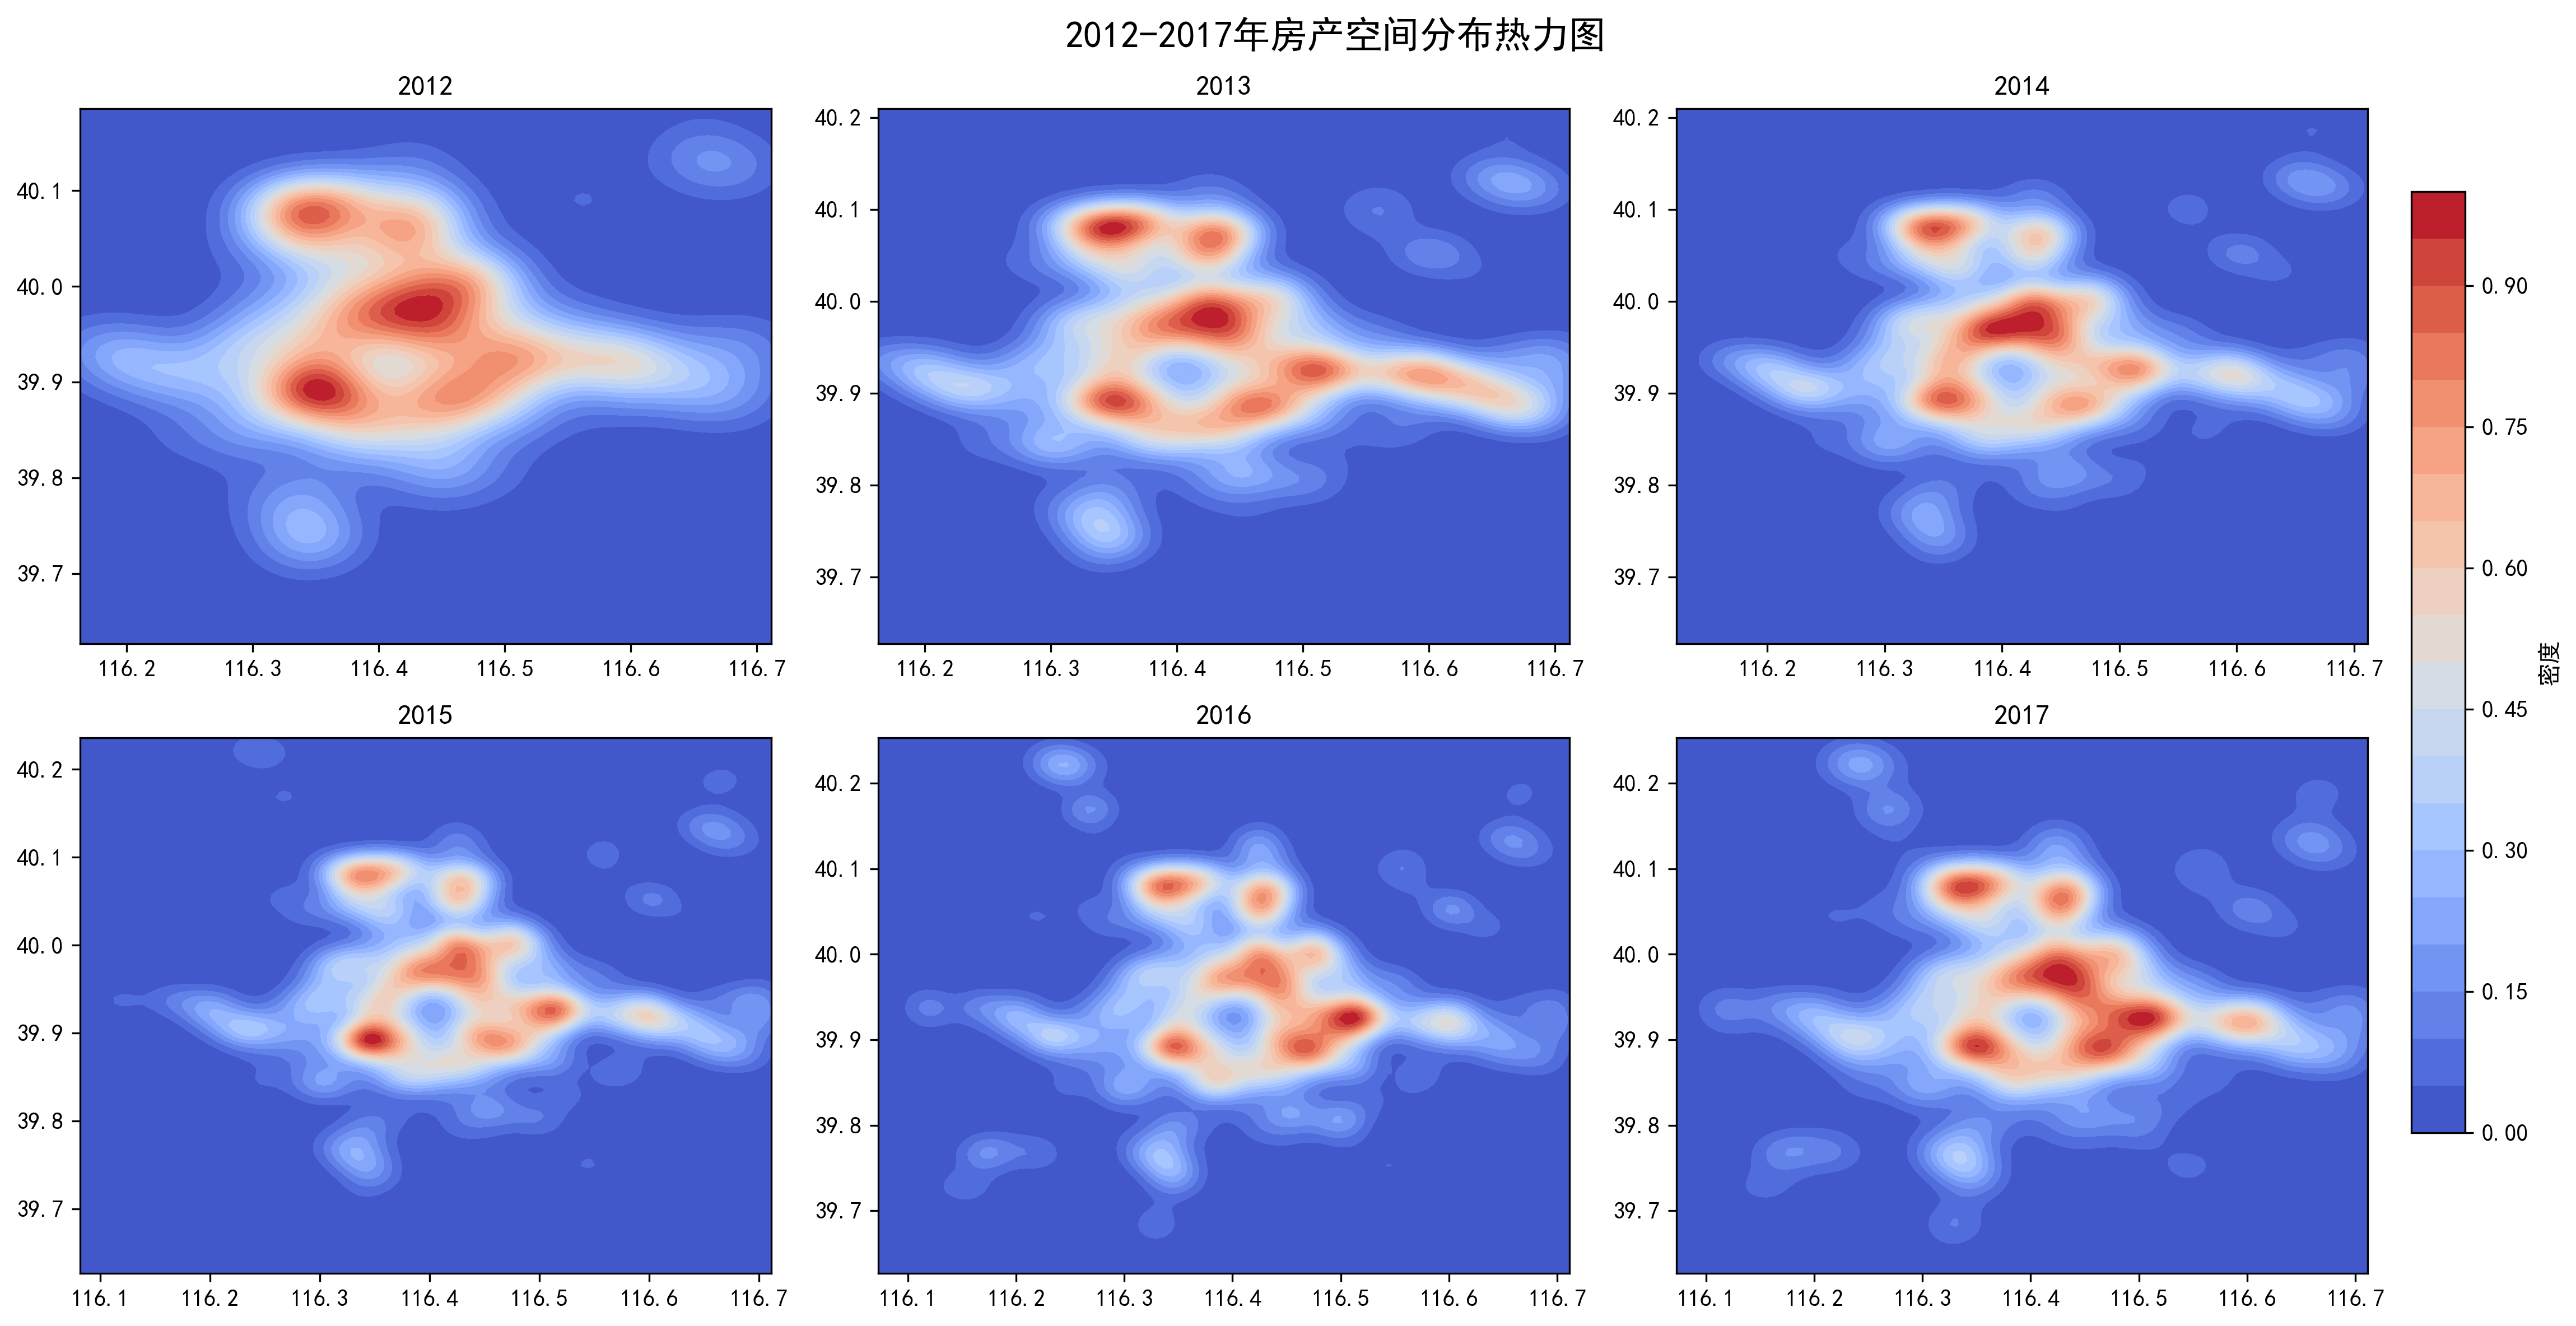

In [8]:
# 绘制房产的空间分布, 分析各年的房产市场
from scipy.stats import kde
nrows = 2
ncols = 3
year_list = np.array(['2012', '2013', '2014', '2015', '2016', '2017']).reshape(nrows, ncols)
fig, ax = plt.subplots(nrows, ncols, figsize = (16, 8), dpi = 300)

# 绘制房产空间分布核密度图
for irow in range(nrows):
    for icol in range(ncols):
        year_data = data[data['year'] == year_list[irow][icol]]
        x = year_data['lng']
        y = year_data['lat']
        # 使用KDE来计算密度
        k = kde.gaussian_kde([x, y])
        xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        zi = (zi -  zi.min()) / (zi.max() - zi.min())
        contour = ax[irow][icol].contourf(xi, yi, zi.reshape(xi.shape), levels=20, cmap='coolwarm', vmin=0, vmax=1)
        ax[irow][icol].set_title(f'{year_list[irow][icol]}')
# 添加共享的colorbar
fig.subplots_adjust(right = 0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('密度')
fig.suptitle('2012-2017年房产空间分布热力图',fontsize = 16)
plt.tight_layout(rect=[0, 0, 0.9, 1])
        #plt.xlabel('经度 (Longitude)', fontsize = 4)
        # plt.ylabel('纬度 (Latitude)',fontsize = 4)

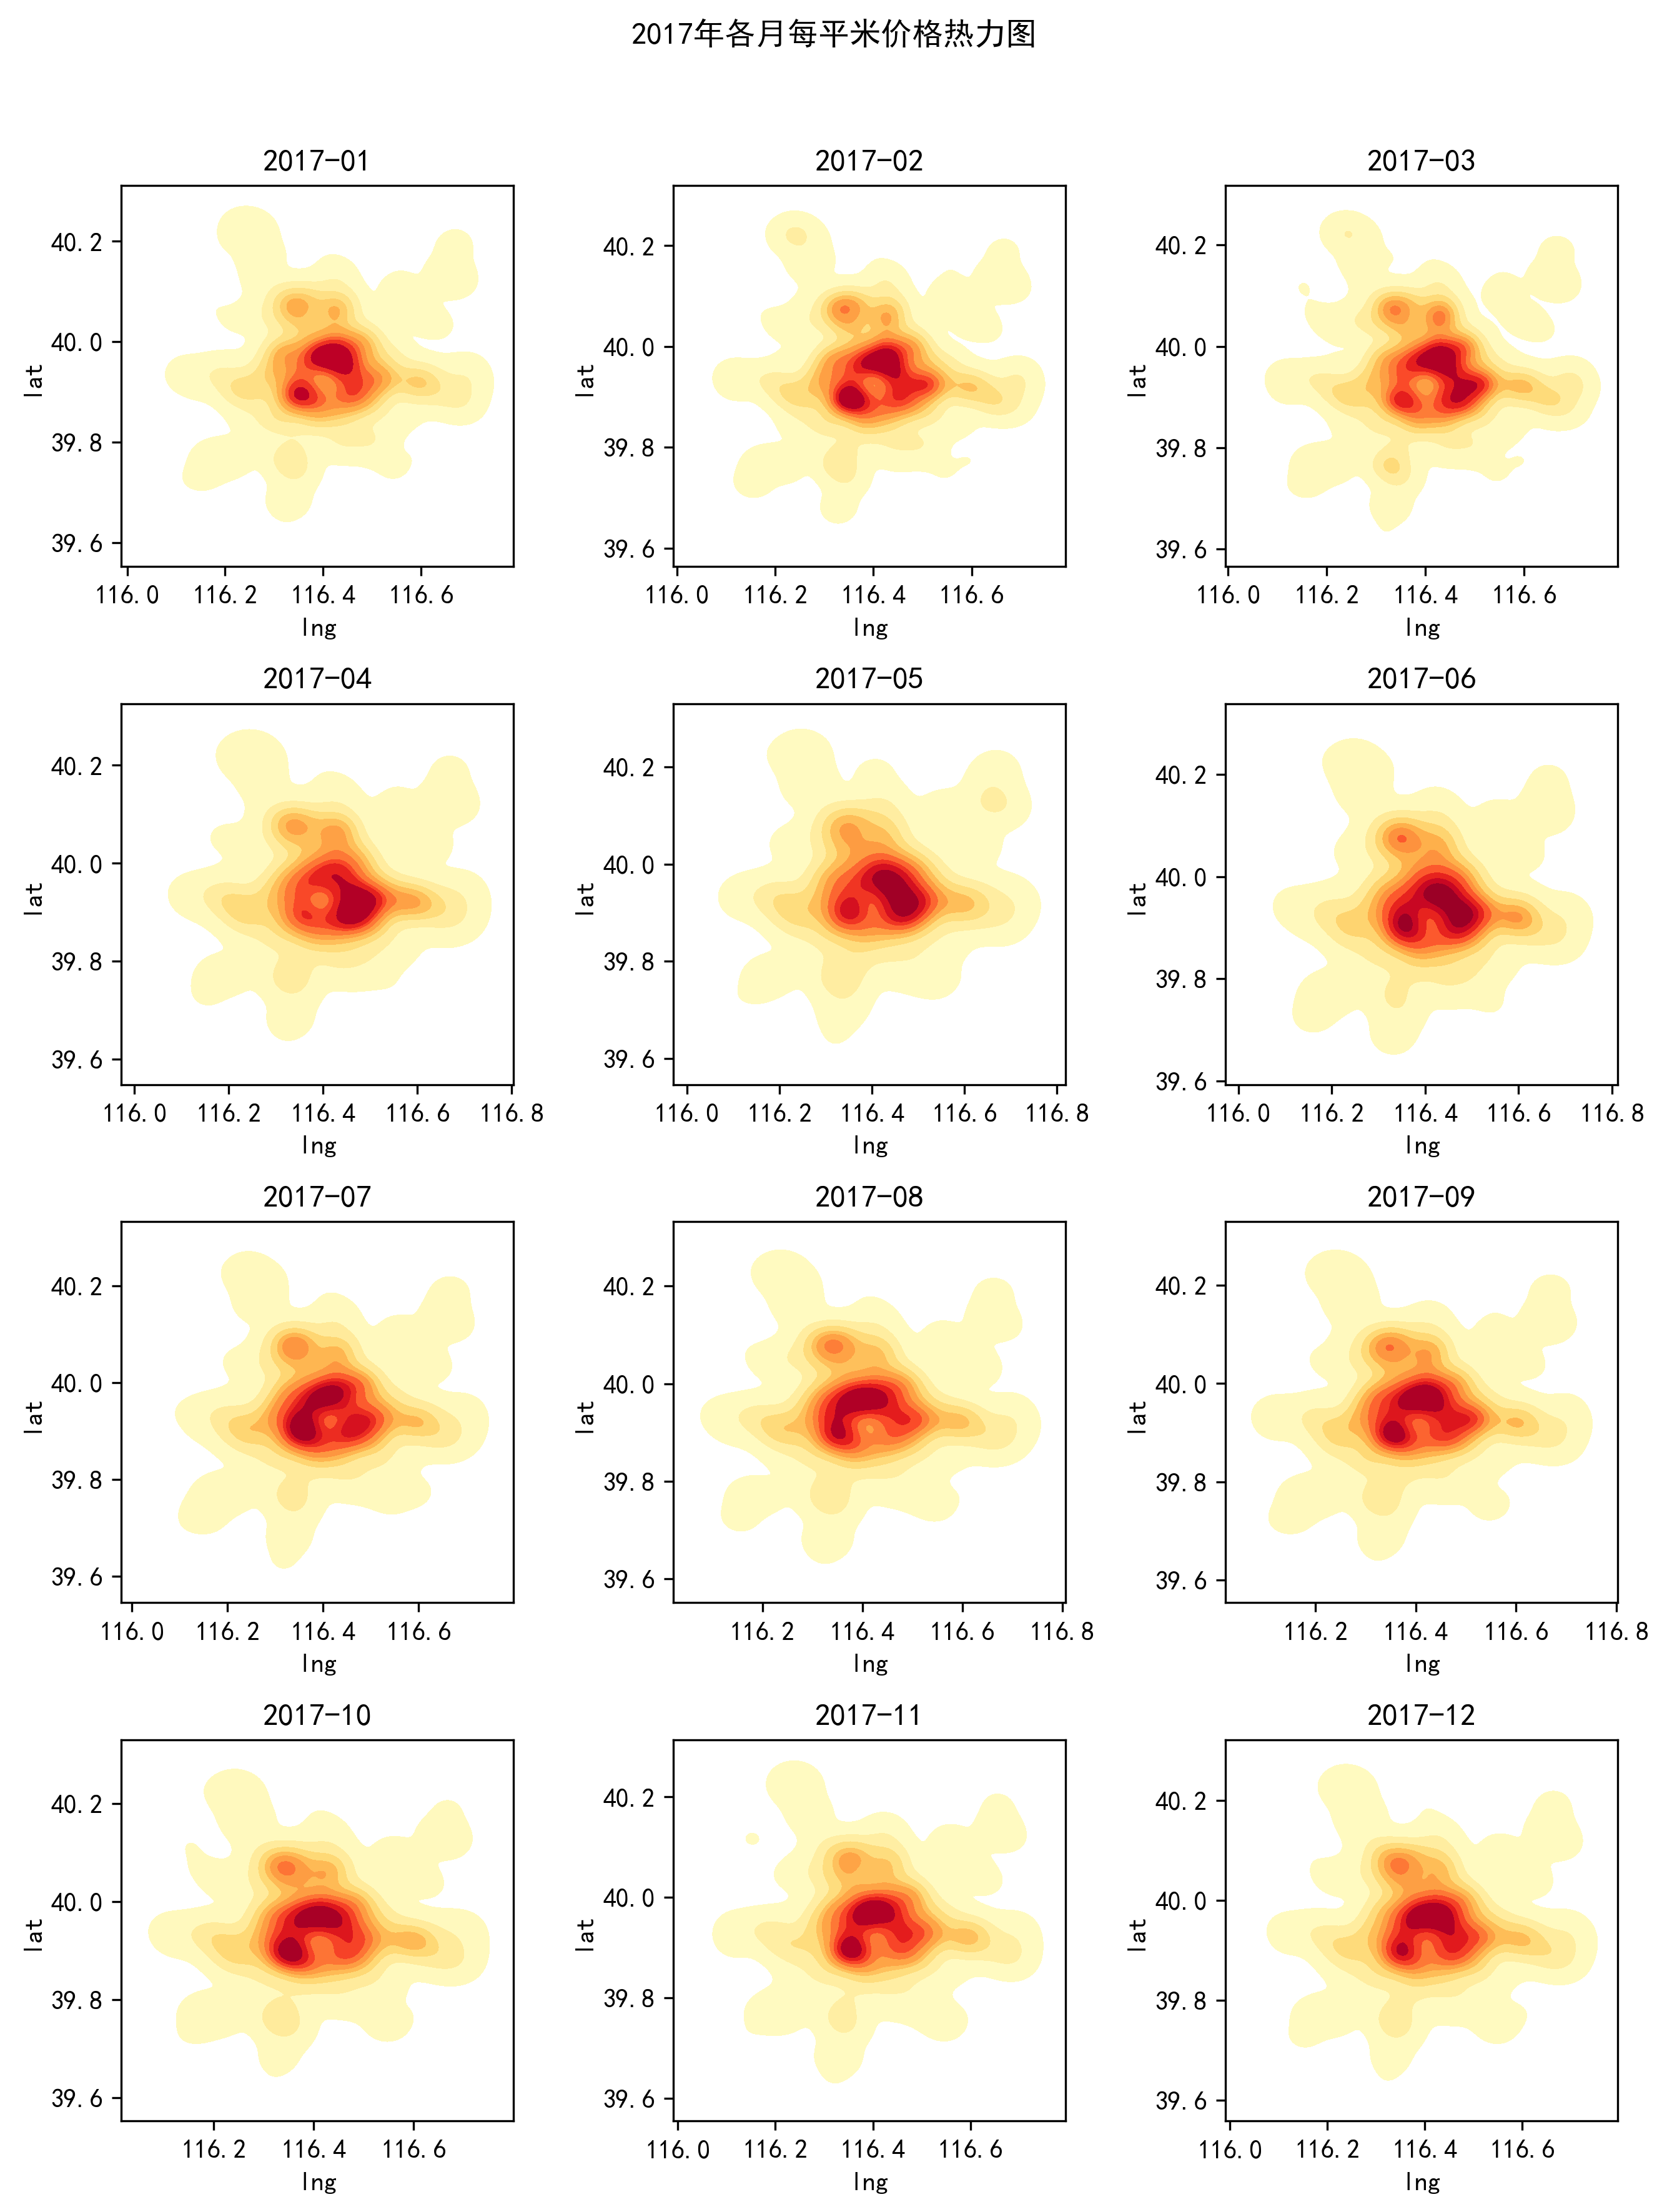

In [9]:
# 分析2017年各月的房价
month_list = np.sort(data[data['year'] == '2017']['month'].unique()).reshape(4, 3)
fig, ax = plt.subplots(figsize = (9, 12),nrows=4, ncols=3)
fig.dpi = 300
for irow in range(4):
    for icol in range(3):
        month_data = data[data['month'] == month_list[irow][icol]]
        price_normalized = (month_data['price_per_square'] - month_data['price_per_square'].min()) / (month_data['price_per_square'].max() - month_data['price_per_square'].min())
        sns.kdeplot(x=month_data['lng'], y=month_data['lat'], weights=month_data['price_per_square'],
                cmap="YlOrRd", fill=True, thresh=0.01,ax = ax[irow][icol])
        ax[irow][icol].set_title(f'{month_list[irow][icol]}')
fig.suptitle('2017年各月每平米价格热力图')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [10]:
# 分析不同区有无地铁的单位房价
data_2017 = data[data['year'] == '2017']
data_2017['district'] = data_2017['district'].astype(int)
data_2017.sort_values(by = 'district', inplace= True)
data1 = data_2017.groupby(by=['subway','district'])['price_per_square'].agg(average = 'mean').reset_index()

C:\Users\wesley\AppData\Local\Temp\ipykernel_10808\850509635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2017['district'] = data_2017['district'].astype(int)
C:\Users\wesley\AppData\Local\Temp\ipykernel_10808\850509635.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2017.sort_values(by = 'district', inplace= True)


In [ ]:
data1['subway'] = data1['subway'].astype(str)

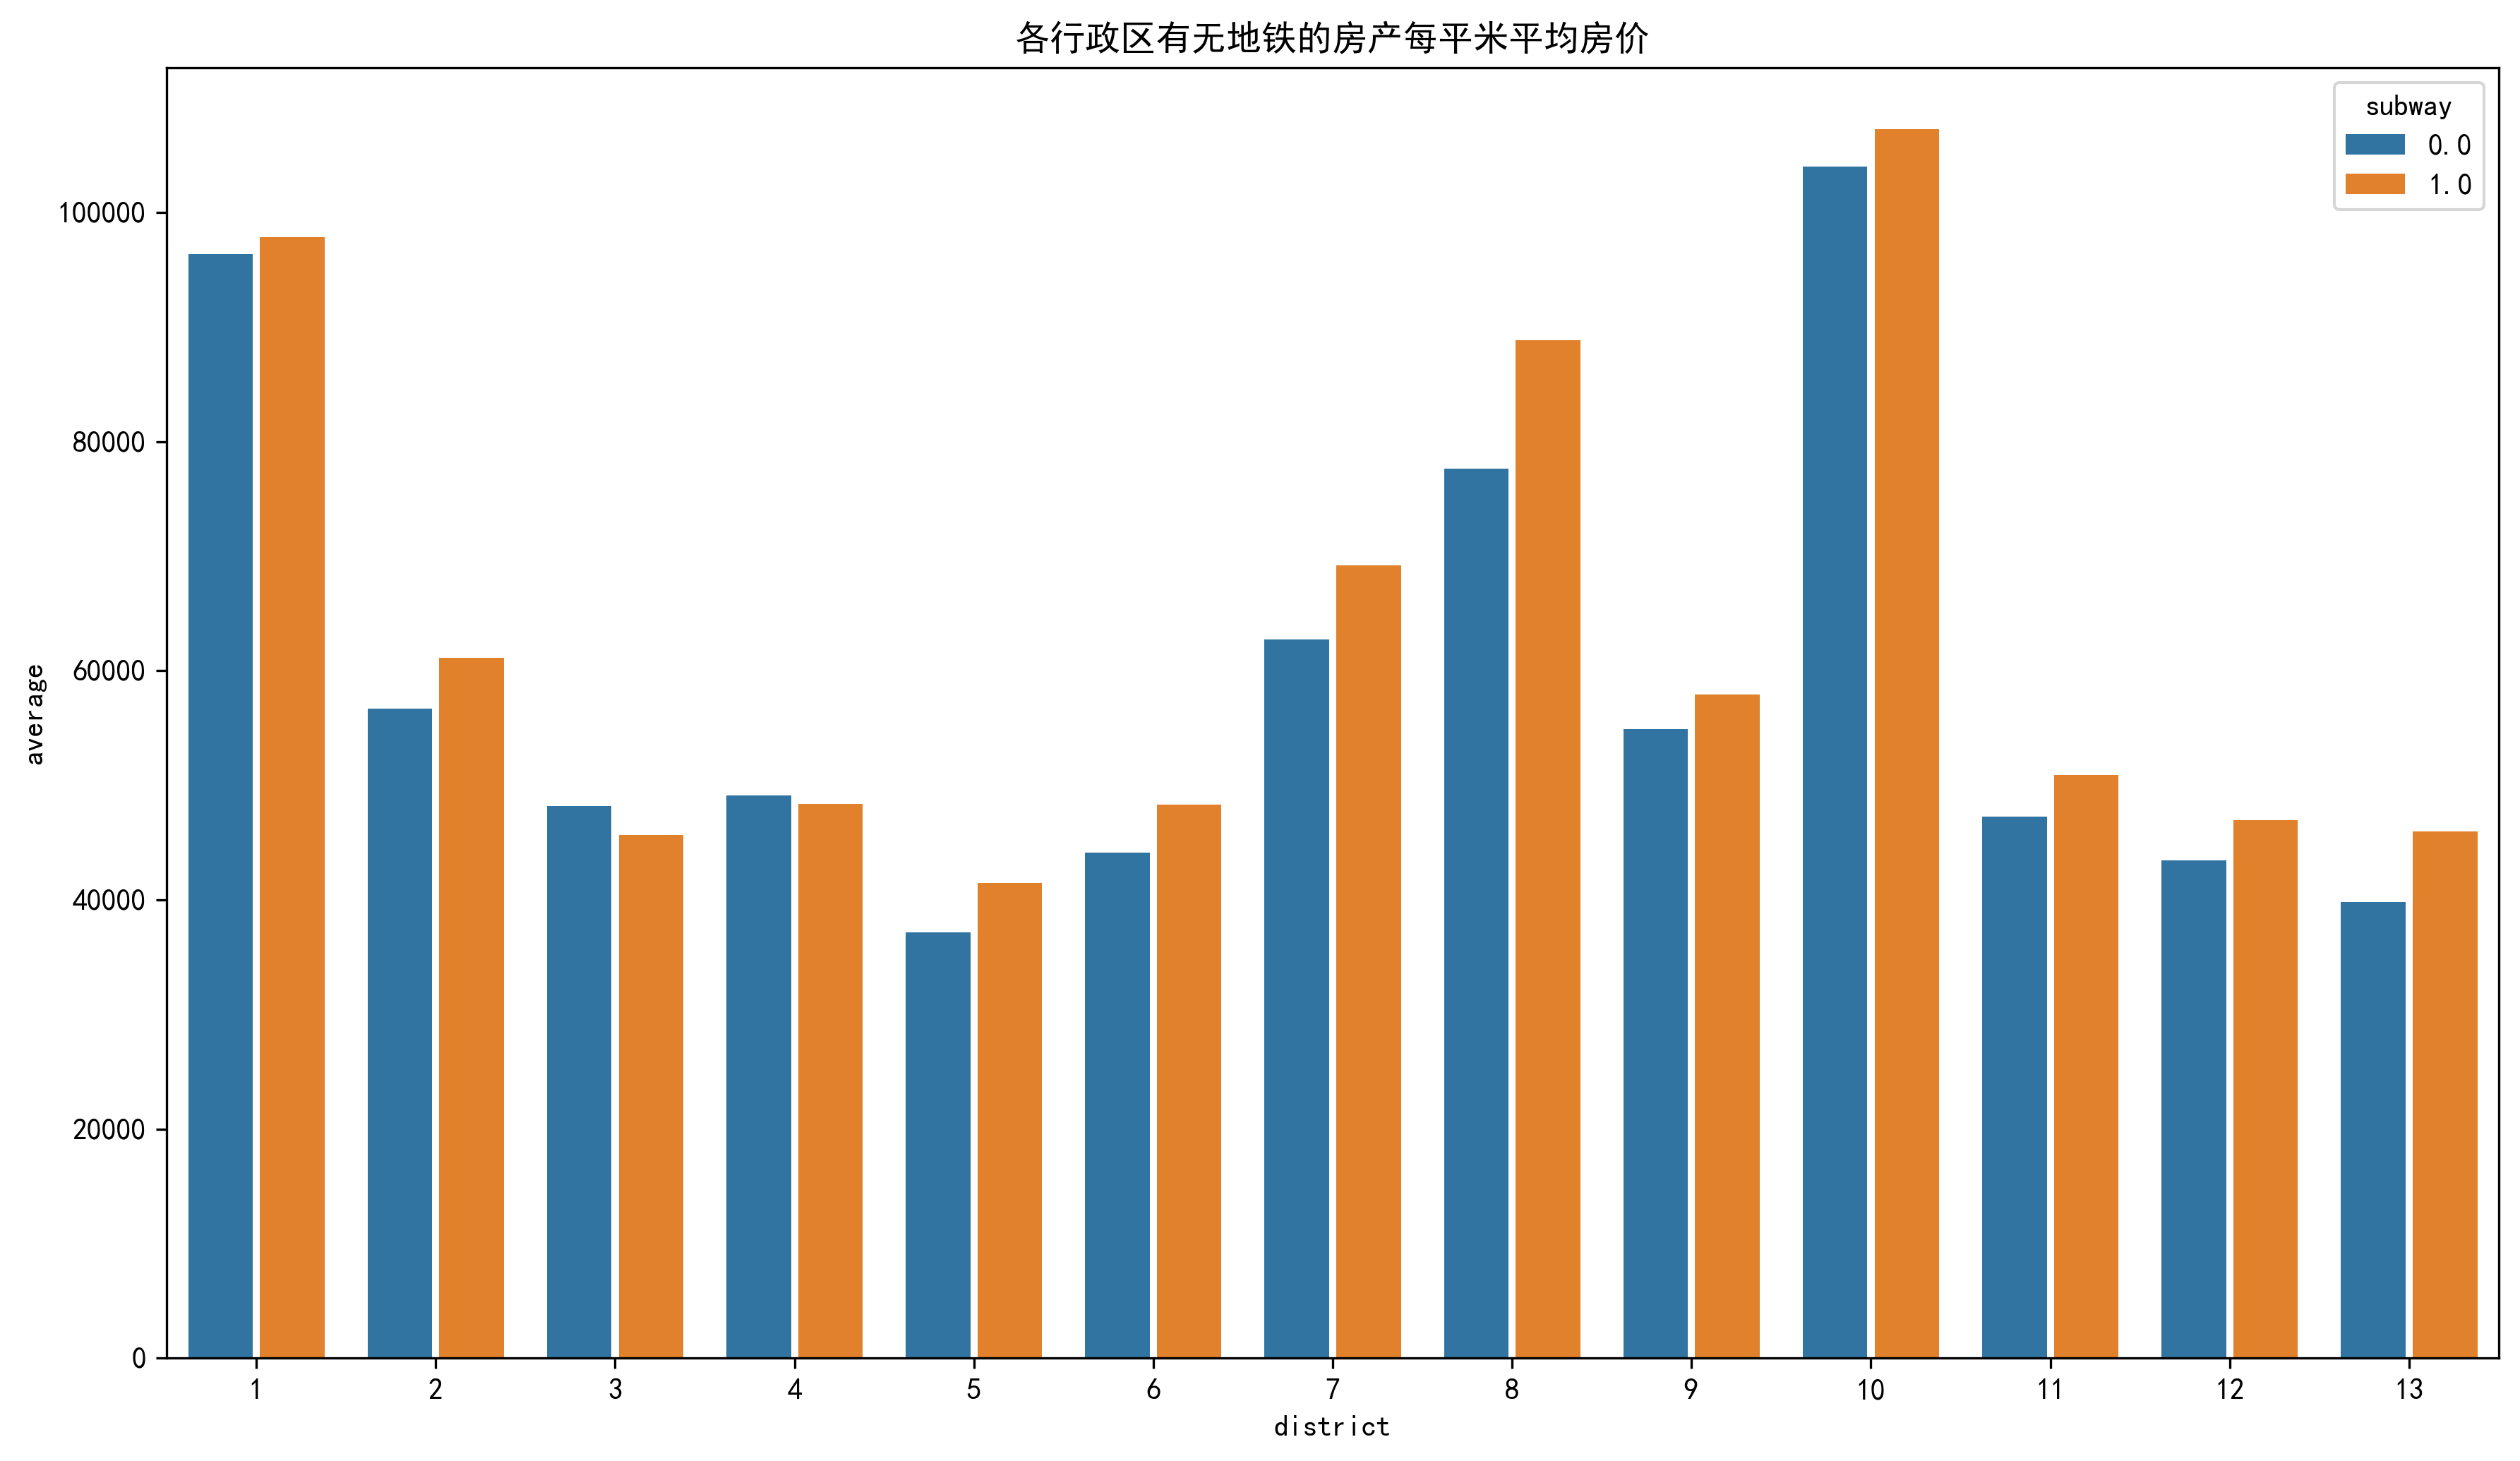

In [22]:
plt.figure(figsize=(12, 7), dpi = 300)
sns.barplot(data= data1, x = 'district', y = 'average', hue = 'subway',gap=.1)
plt.title('各行政区有无地铁的房产每平米平均房价')
plt.tight_layout()

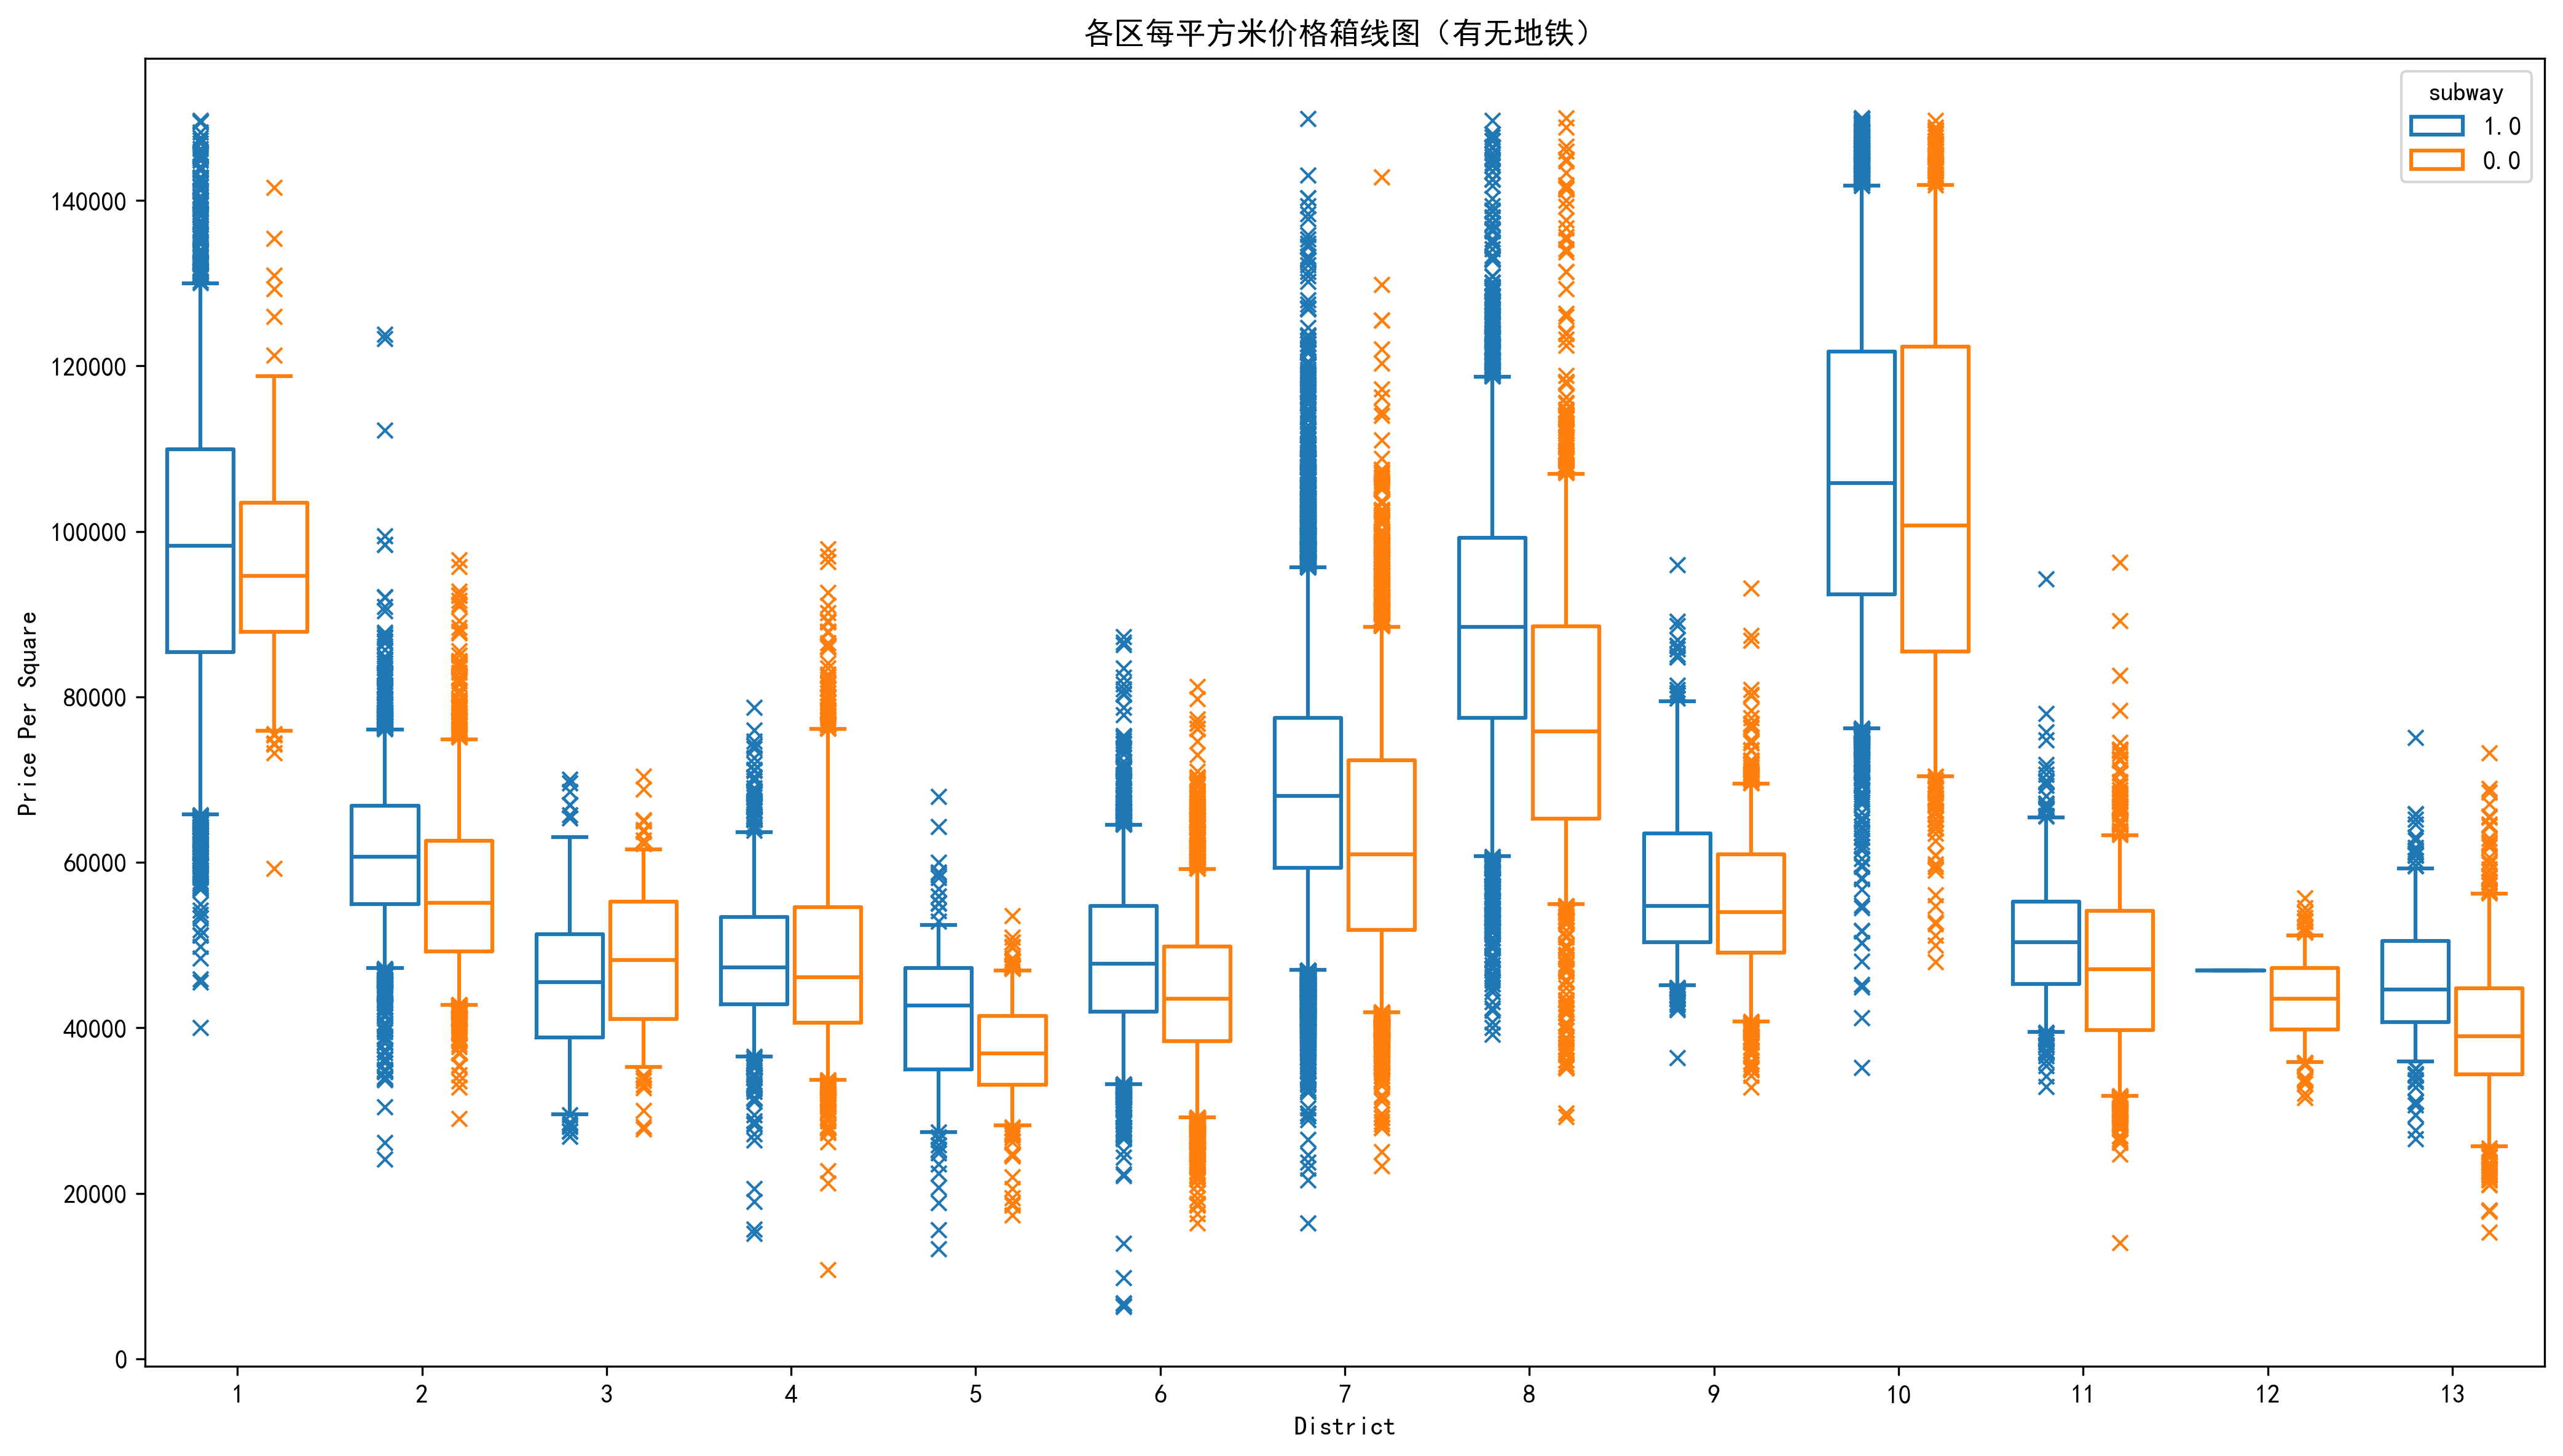

In [20]:
plt.figure(figsize=(14, 8), dpi=300)
sns.boxplot(data=data_2017, x ='district', y ='price_per_square', hue='subway', 
            fill=False, gap=.1, whis=(5, 95), flierprops ={"marker": 'x'})
# for outlier in outliers:
#     plt.scatter(outlier[0], outlier[1], color='red', s=100, zorder=5, edgecolors='black')
plt.title("各区每平方米价格箱线图（有无地铁）")
plt.ylabel('Price Per Square')
plt.xlabel('District')
plt.tight_layout()
plt.show()

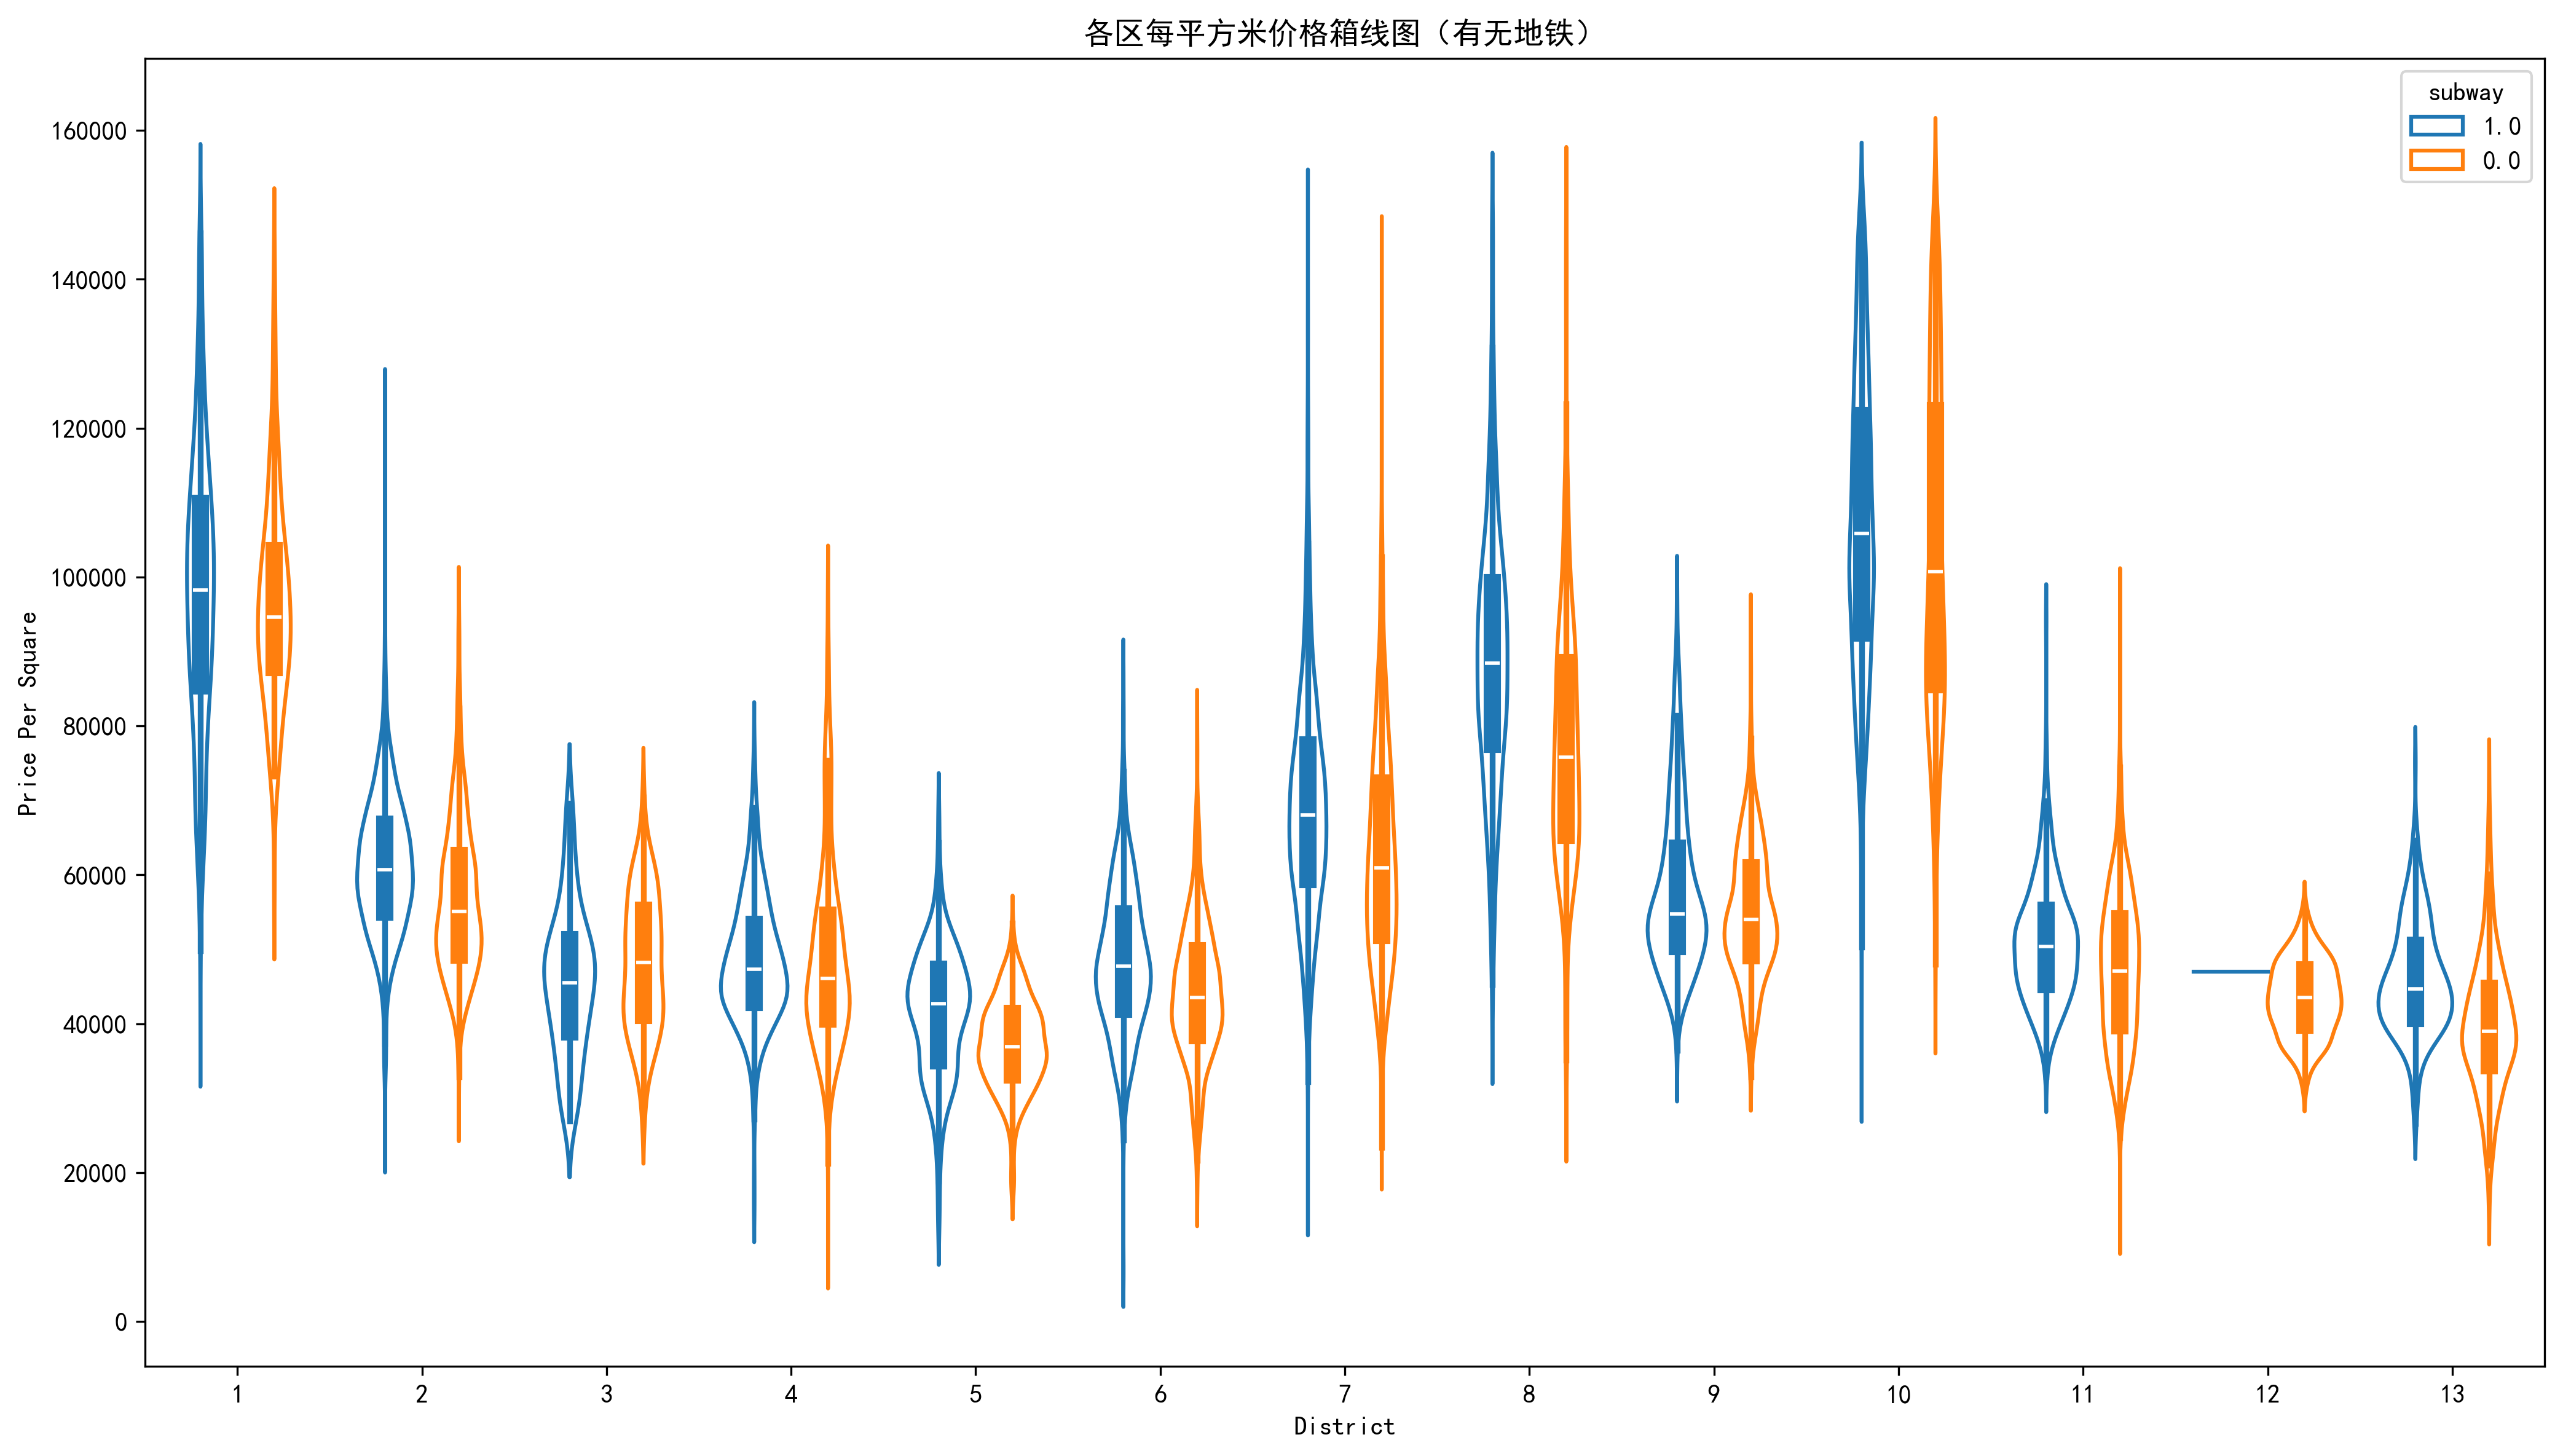

In [21]:
plt.figure(figsize=(14, 8), dpi=300)
sns.violinplot(data=data_2017, x ='district', y ='price_per_square', hue='subway', 
            fill=False)
# for outlier in outliers:
#     plt.scatter(outlier[0], outlier[1], color='red', s=100, zorder=5, edgecolors='black')
plt.title("各区每平方米价格箱线图（有无地铁）")
plt.ylabel('Price Per Square')
plt.xlabel('District')
plt.tight_layout()
plt.show()